In [2]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
#from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict

%matplotlib inline
np.random.seed(1)

In [47]:

def load_data():
    train = h5py.File("datasets/train_signs.h5" , "r")
    test = h5py.File("datasets/test_signs.h5" , "r")
    train_set_x = np.array(train["train_set_x"][:]) 
    train_set_y = np.array(train["train_set_y"][:])
    test_set_x = np.array(test["test_set_x"][:])
    test_set_y = np.array(test["test_set_y"][:])

    num_classes = np.array(test["list_classes"][:])
    print(train_set_y.shape)
    train_set_y = train_set_y.reshape(1,train_set_y.shape[0])
    test_set_y = test_set_y.reshape(1,test_set_y.shape[0])
    return train_set_x,train_set_y,test_set_x,test_set_y,num_classes 

In [43]:
def random_mini_batches(X, Y, batch_size = 64, seed = 0):
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_x = X[:, permutation]
    shuffled_y = Y[:,permutation].reshape((Y.shape[0],m))
    no_mini_batch = np.floor(m/batch_size)
    
    for i in range(0,int(no_mini_batch)):
        mini_x = shuffled_x[:,i*batch_size:(i+1)*batch_size]
        mini_y = shuffled_y[:,batch_size*i:batch_size*(i+1)]
        mini_batch = (mini_x,mini_y)
        mini_batches.append(mini_batch)
    
    if m%batch_size != 0:
        mini_x = shuffled_x[:,batch_size*(i+1):]
        mini_y = shuffled_y[:,batch_size*(i+1):]
        mini_batch = (mini_x,mini_y)
        mini_batches.append(mini_batch)
    
    return mini_batches


In [5]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y


In [27]:
def create_placeholders(n_x,n_y):
    
    X = tf.placeholder(tf.float32,[n_x,None],name = 'X')
    Y = tf.placeholder(tf.float32,[n_y,None],name = "Y")
    return X,Y

In [91]:
def initialize_parameters(layer_dims):
    tf.set_random_seed(1)
    n = len(layer_dims)
    parameters = {}
    for l in range(0,n):
        print(l)
        if l != len(layer_dims)-1:
            parameters["W" + str(l+1)] = tf.get_variable("W"+str(l+1),[layer_dims[l],layer_dims[l+1]],initializer = tf.contrib.layers.xavier_initializer(seed = 1))
            parameters["b"+str(l+1)] = tf.get_variable("b"+str(l+1),[layer_dims[l+1],1],initializer = tf.zeros_initializer())
    
    return parameters    

In [25]:
def compute_cost(Z3,Y):
    
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits,labels = labels))
    print(type(cost),type(Y))
    return cost


In [90]:
def forward_propagation(X,parameters,layer_dims):
    n = len(layer_dims)
    A = X
    for l in range(1,n):
        Z = tf.add(tf.matmul(tf.transpose(parameters["W"+str(l)]),A),parameters["b"+str(l)])
        A = tf.nn.relu(Z)
        
    return Z  

(1080,)
y = 2


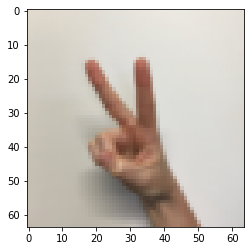

In [48]:
train_set_x_or,train_set_y_or,test_set_x_or,test_set_y_or,classes = load_data()
# Example of a picture
index = 4
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [49]:
# Flatten the training and test images
train_set_x_F = train_set_x_or.reshape(-1,train_set_x_or.shape[0])
test_set_x_F = test_set_x_or.reshape(-1,test_set_x_or.shape[0])
train_set_x = train_set_x_F/255
test_set_x = test_set_x_F/255

train_set_y = convert_to_one_hot(train_set_y_or,len(classes))
test_set_y = convert_to_one_hot(test_set_y_or,len(classes))
print ("number of training examples = " + str(train_set_x.shape[1]))
print ("number of test examples = " + str(test_set_x.shape[1]))
print ("X_train shape: " + str(train_set_x.shape))
print ("Y_train shape: " + str(train_set_y.shape))
print ("X_test shape: " + str(test_set_x.shape))
print ("Y_test shape: " + str(test_set_y.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (12288, 1080)
Y_train shape: (6, 1080)
X_test shape: (12288, 120)
Y_test shape: (6, 120)


In [73]:
def model(X_train, Y_train, X_test, Y_test,layer_dims, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
 
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3
    (n_x,m) = X_train.shape
    n_y = X_train.shape[0]
    costs = []                                      # To keep track of the cost
    
    X,Y = create_placeholders(layer_dims[0],layer_dims[-1])
    parameters = initialize_parameters(layer_dims)
    Z = forward_propagation(X,parameters,layer_dims)
    cost = compute_cost(Z,Y)

    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

    init = tf.global_variables_initializer()

    with tf.Session() as sess:
        
        sess.run(init)
        
        for epoch in range(num_epochs):
            seed = seed+1
            epoch_cost = 0
            num_minibatches = int(m / minibatch_size)
            mini_batches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            
            for mini_batch in mini_batches:

                (mini_X, mini_Y) = mini_batch
                _ , minibatch_cost = sess.run([optimizer,cost],feed_dict = {X:mini_X,Y:mini_Y})
                
                epoch_cost += minibatch_cost / minibatch_size

            
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)

        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per fives)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        correct_prediction = tf.equal(tf.argmax(Z), tf.argmax(Y))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

In [89]:
layer_dims = [12288,25,12,6]
parameters = model(train_set_x,train_set_y,test_set_x,test_set_y,layer_dims)

<class 'tensorflow.python.framework.ops.Tensor'> <class 'tensorflow.python.framework.ops.Tensor'>
Cost after epoch 0: 1.910650
Cost after epoch 100: 1.903758


KeyboardInterrupt: 